# Dataset reference
#### https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification?resource=download

# Imports

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1500)
pd.set_option('display.max_colwidth', 150)  # Aumentar a largura da coluna

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import lightgbm as lgb
import optuna
from optuna.logging import set_verbosity, WARNING
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import *
from sklearn.model_selection import cross_validate, StratifiedKFold
import shap
from optuna.samplers import TPESampler

# Functions

In [5]:
def function_plot_statistics(df, column_name, category, palette='Set2', order=['Normal','Suspect','Pathological']):

    # Tamanho da figura:
    plt.figure(figsize=(14, 3.5)) 
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x=category, y=column_name, data=df, palette=palette, order=order, showfliers=False)
    plt.title(f'Boxplot - {column_name.upper()}')

    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=column_name, hue=category, kde=True, stat='density', palette=palette, common_norm=False, legend=True)
    plt.title(f'Histograma - {column_name.upper()}')
    plt.tight_layout()
    plt.show()  

    display(df.groupby(category)[column_name].describe().round(2).reset_index())

    quantiles = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    display(df.groupby(category)[column].quantile(quantiles).unstack().round(2))

In [6]:
list_tipo_modelo = []
list_train_recall = []
list_train_precision = []
list_train_f1 = []
list_test_recall = []
list_test_precision = []
list_test_f1 = []

In [7]:
def lgbm_binary_objective(trial, X_train, y_train):
        
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity':-1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-8, 1.0)
    }
    
    model = lgb.LGBMClassifier(**param)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    
    return score 

In [8]:
def lgbm_train_test_binary_model(nome_exibicao, X_train, y_train, show_CM=False, n_trials=50):

    print(f'#---------------------------------------------- {nome_exibicao.upper()} ------------------------------------------------#')
    
    # Configurações de log do Optuna
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)  # Mostra apenas mensagens de erro
    
    # Criando o estudo de otimização
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    
    # Otimizando o modelo
    study.optimize(lambda trial: lgbm_binary_objective(trial, X_train, y_train), n_trials=n_trials, show_progress_bar=True)

    print(f'\n>> Treino: {nome_exibicao}')
    
    # Melhor conjunto de hiperparâmetros
    best_params = study.best_params
    # print(f'\n> Melhores parâmetros: {best_params}')
    
    # Treinando o modelo final com os melhores parâmetros
    best_model = lgb.LGBMClassifier(**best_params)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    #------------------------------------------------------ Binary ------------------------------------------------------#
    train_scores = cross_validate(estimator=best_model, 
                                  X=X_train, 
                                  y=y_train, 
                                  n_jobs=-1,
                                  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                  scoring=('precision', 'recall', 'f1'))  
    
    train_results = {
        'Precision': f"{round(train_scores['test_precision'].mean(), 4)} ± {round(train_scores['test_precision'].std(), 4)}",
        'Recall': f"{round(train_scores['test_recall'].mean(), 4)} ± {round(train_scores['test_recall'].std(), 4)}",
        'F1': f"{round(train_scores['test_f1'].mean(), 4)} ± {round(train_scores['test_f1'].std(), 4)}"
    }

    # Cálculo de TP, FP, FN
    TP = np.sum((y_test == 3) & (y_pred == 1))
    FP = np.sum((y_test != 3) & (y_pred == 1))
    FN = np.sum((y_test == 3) & (y_pred == 0))
    
    # Cálculo da precisão, recall e F1-score
    precision_test = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall_test = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_test = (2 * precision_test * recall_test) / (precision_test + recall_test) if (precision_test + recall_test) > 0 else 0

    test_results = {
        'Precision': f"{round(precision_test, 4)}",
        'Recall': f"{round(recall_test, 4)}",
        'F1': f"{round(f1_test, 4)}"
    }

    print('\n> Resultados de treino:', train_results)        
    print('\n> Resultados de teste:', test_results)
    print('\n')


    # Adicionar resultados
    list_tipo_modelo.append(nome_exibicao)
    list_train_recall.append(round(train_scores['test_recall'].mean(), 4))
    list_train_precision.append(round(train_scores['test_precision'].mean(), 4))
    list_train_f1.append(round(train_scores['test_f1'].mean(), 4))
    list_test_recall.append(recall_test)
    list_test_precision.append(precision_test)
    list_test_f1.append(f1_test)
    
    # Matriz de confusão 
    if show_CM==True:
        fig = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        fig.figure_.suptitle('Matriz de Confusão')
        plt.show()

    return best_model

In [9]:
def lgbm_multiclass_objective(trial):
    
    param = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-8, 1.0),
        'num_classes': 3,
        # 'class_weight': 'balanced',  
    }
    
    model = lgb.LGBMClassifier(**param)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro').mean()  # Usa f1_macro para multiclasse
    
    return score

In [10]:
def lgbm_train_test_multiclass_model(nome_exibicao, X_train, y_train, show_CM=False, n_trials=50):

    print(f'#---------------------------------------------- {nome_exibicao.upper()} ------------------------------------------------#')
    
    # Configurações de log do Optuna
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)  # Mostra apenas mensagens de erro
    
    # Criando o estudo de otimização
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    
    # Otimizando o modelo
    study.optimize(lgbm_multiclass_objective, n_trials=n_trials, show_progress_bar=True)

    print(f'\n>> Treino: {nome_exibicao}')
    
    # Melhor conjunto de hiperparâmetros
    best_params = study.best_params
    #print(f'\n> Melhores parâmetros: {best_params}')
    
    # Treinando o modelo final com os melhores parâmetros
    best_model = lgb.LGBMClassifier(**best_params)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    #------------------------------------------------------ Multiclass ------------------------------------------------------#


    train_scores = cross_validate(estimator=best_model, 
                                   X=X_train, 
                                   y=y_train, 
                                   n_jobs=-1,
                                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                   scoring=('precision_macro', 'recall_macro', 'f1_macro'))  
    
    train_results = {
        'Precision': f"{round(train_scores['test_precision_macro'].mean(), 4)} ± {round(train_scores['test_precision_macro'].std(), 4)}",
        'Recall': f"{round(train_scores['test_recall_macro'].mean(), 4)} ± {round(train_scores['test_recall_macro'].std(), 4)}",
        'F1': f"{round(train_scores['test_f1_macro'].mean(), 4)} ± {round(train_scores['test_f1_macro'].std(), 4)}"
    }
        
    test_results = {
        'Precision': f"{round(precision_score(y_test, y_pred, average='macro'), 4)}",
        'Recall': f"{round(recall_score(y_test, y_pred, average='macro'), 4)}",
        'F1': f"{round(f1_score(y_test, y_pred, average='macro'), 4)}"
    }
        
    print('\n> Resultados de treino:', train_results)        
    print('\n> Resultados de teste:', test_results)
    print('\n')

    # Adicionar resultados
    list_tipo_modelo.append(nome_exibicao)
    list_train_recall.append(round(train_scores['test_recall_macro'].mean(), 4))
    list_train_precision.append(round(train_scores['test_precision_macro'].mean(), 4))
    list_train_f1.append(round(train_scores['test_f1_macro'].mean(), 4))
    list_test_recall.append(round(recall_score(y_test, y_pred, average='macro'), 4))  
    list_test_precision.append(round(precision_score(y_test, y_pred, average='macro'), 4))  
    list_test_f1.append(round(f1_score(y_test, y_pred, average='macro'), 4)) 

    # Matriz de confusão 
    
    if show_CM==True:
        fig = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        fig.figure_.suptitle('Matriz de Confusão')
        plt.show()

    return best_model

# Data

In [11]:
df_mastertable = pd.read_csv('fetal_health.csv')

In [12]:
df_mastertable.head(2)

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0


In [13]:
# Fetal health: 
# 1 - Normal 
# 2 - Suspect 
# 3 - Pathological

df_mastertable['fetal_health'] = df_mastertable['fetal_health'].astype('int64')

df_mastertable['class_name'] = 'Normal'
df_mastertable.loc[(df_mastertable['fetal_health'] == 2), 'class_name'] = 'Suspect'
df_mastertable.loc[(df_mastertable['fetal_health'] == 3), 'class_name'] = 'Pathological'

In [14]:
classes_distribution = df_mastertable.groupby(['fetal_health','class_name']).size()*100/len(df_mastertable)

df_classes_distribution = pd.merge(df_mastertable.groupby(['fetal_health','class_name']).size().reset_index(name='count'), 
                                   classes_distribution.reset_index(name='percentage').round(2), 
                                   on=['fetal_health','class_name'], 
                                   how='left')

df_classes_distribution

,fetal_health,class_name,count,percentage
0,1,Normal,1655,77.85
1,2,Suspect,295,13.88
2,3,Pathological,176,8.28


In [15]:
df_mastertable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 23 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [16]:
features_list = [col for col in df_mastertable.columns.to_list() if col not in ['fetal_health','class_name']]

print('>> Features:  ',features_list)

>> Features:   ['baseline value', 'accelerations', 'fetal_movement', 'uterine_contractions', 'light_decelerations', 'severe_decelerations', 'prolongued_decelerations', 'abnormal_short_term_variability', 'mean_value_of_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'mean_value_of_long_term_variability', 'histogram_width', 'histogram_min', 'histogram_max', 'histogram_number_of_peaks', 'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean', 'histogram_median', 'histogram_variance', 'histogram_tendency']


# Exploratory Data Analysis

## Multiclass EDA

In [17]:
# for column in features_list:
    
#     print("\n>> Feature:", column)
#     function_plot_statistics(df_mastertable, column, category='class_name', palette='Set2')
#     print("\n")

# Preparação dos dados para modelagem

## Grupo I: criação de X e Y multiclasse (com split de treino e teste)

In [18]:
X = df_mastertable.drop(['fetal_health', 'class_name'], axis=1)
y = df_mastertable['fetal_health']    

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
print(f'>> Distribuição dos dados:')
print(f'\n> Quantidade de dados de treino: {X_train.shape[0]}')
print(f'> Quantidade de dados label 1 "Normal" de treino: {X_train[y_train == 1].shape[0]}')
print(f'> Quantidade de dados label 2 "Suspect" de treino: {X_train[y_train == 2].shape[0]}')
print(f'> Quantidade de dados label 3 "Pathological" de treino: {X_train[y_train == 3].shape[0]}')

print(f'\n> Quantidade de dados de teste: {X_test.shape[0]}')
print(f'> Quantidade de dados label 1 "Normal" de treino: {X_test[y_test == 1].shape[0]}')
print(f'> Quantidade de dados label 2 "Suspect" de treino: {X_test[y_test == 2].shape[0]}')
print(f'> Quantidade de dados label 3 "Pathological" de treino: {X_test[y_test == 3].shape[0]}')

>> Distribuição dos dados:

> Quantidade de dados de treino: 1488
> Quantidade de dados label 1 "Normal" de treino: 1159
> Quantidade de dados label 2 "Suspect" de treino: 194
> Quantidade de dados label 3 "Pathological" de treino: 135

> Quantidade de dados de teste: 638
> Quantidade de dados label 1 "Normal" de treino: 496
> Quantidade de dados label 2 "Suspect" de treino: 101
> Quantidade de dados label 3 "Pathological" de treino: 41


## Grupo II: criação da classe binária e exclusão da classe excedente

In [20]:
#-------------------- Filtrar X e y de treino para classificação binária --------------------#

# Excluindo 'Normal' para criar X_train_most_critical e y_train_most_critical
mask_most_critical = df_mastertable['class_name'][y_train.index] != 'Normal'
X_train_most_critical = X_train[mask_most_critical].copy()
y_train_most_critical = y_train[mask_most_critical].copy()

# Excluindo 'Pathological' para criar X_train_less_critical e y_train_less_critical
mask_less_critical = df_mastertable['class_name'][y_train.index] != 'Pathological'
X_train_less_critical = X_train[mask_less_critical].copy()
y_train_less_critical = y_train[mask_less_critical].copy()

# Excluindo 'Suspect' para criar X_train_extreme e y_train_extreme
mask_extreme = df_mastertable['class_name'][y_train.index] != 'Suspect'
X_train_extreme = X_train[mask_extreme].copy()
y_train_extreme = y_train[mask_extreme].copy()

## Grupo III: criação da classe binária e criação de ruído de 100% da classe intermediária

In [21]:
#-------------------- Adicionar ruído a X e y de treino para classificação binária --------------------#

# Criando o target noise, que é a classe intermediária (Suspect)
mask_target_noise = df_mastertable['class_name'][y_train.index] == 'Suspect'

# Filtrando X_train e y_train usando a máscara
X_train_noise = X_train[mask_target_noise].copy()
y_train_noise = y_train[mask_target_noise].copy()

In [22]:
# Add noise to the 'extreme' dataframe
X_train_with_target_noise = pd.concat([X_train_extreme, X_train_noise])
y_train_with_target_noise = pd.concat([y_train_extreme, y_train_noise])

# Transformar o label de 'Suspect' (2) para 'Pathological' (3)
y_train_with_target_noise = y_train_with_target_noise.replace({2: 3})

# Print do resultado
print(f'> Classes resultantes: {y_train_with_target_noise.reset_index().fetal_health.unique()}')
print(f'\n> Quantidade de dados label 1 "Normal" de treino: {X_train_with_target_noise[y_train_with_target_noise == 1].shape[0]}')
print(f'> Quantidade de dados label 3 "Pathological" de treino: {X_train_with_target_noise[y_train_with_target_noise == 3].shape[0]}')

> Classes resultantes: [1 3]

> Quantidade de dados label 1 "Normal" de treino: 1159
> Quantidade de dados label 3 "Pathological" de treino: 329


In [23]:
# Add noise to the 'extreme' dataframe
X_train_with_nontarget_noise = pd.concat([X_train_extreme, X_train_noise])
y_train_with_nontarget_noise = pd.concat([y_train_extreme, y_train_noise])

# Transformar o label de 'Suspect' (2) para 'Normal' (1)
y_train_with_nontarget_noise = y_train_with_nontarget_noise.replace({2: 1})

# Print do resultado
print(f'> Classes resultantes: {y_train_with_nontarget_noise.reset_index().fetal_health.unique()}')
print(f'\n> Quantidade de dados label 1 "Normal" de treino: {X_train_with_nontarget_noise[y_train_with_nontarget_noise == 1].shape[0]}')
print(f'> Quantidade de dados label 3 "Pathological" de treino: {X_train_with_nontarget_noise[y_train_with_nontarget_noise == 3].shape[0]}')

> Classes resultantes: [1 3]

> Quantidade de dados label 1 "Normal" de treino: 1353
> Quantidade de dados label 3 "Pathological" de treino: 135


## Grupo IV: criação da classe binária e criação de ruído de 50% da classe intermediária

In [24]:
# Selecionando os índices onde a classe é 'Suspect'
noise_index = y_train[df_mastertable['class_name'][y_train.index] == 'Suspect'].index

# Selecionando 50% desses índices de forma aleatória
noise_index_sample = noise_index.to_series().sample(frac=0.5, random_state=42)

# Criando X_train_noise e y_train_noise com os 50% dos dados de 'Suspect'
X_train_random_noise = X_train.loc[noise_index_sample].copy()
y_train_random_noise = y_train.loc[noise_index_sample].copy()

In [25]:
# Add noise to the 'extreme' dataframe
X_train_with_random_target_noise = pd.concat([X_train_extreme, X_train_random_noise])
y_train_with_random_target_noise = pd.concat([y_train_extreme, y_train_random_noise])

# Transformar o label de 'Suspect' (2) para 'Pathological' (3)
y_train_with_random_target_noise = y_train_with_random_target_noise.replace({2: 3})

# Print do resultado
print(f'> Classes resultantes: {y_train_with_random_target_noise.reset_index().fetal_health.unique()}')
print(f'\n> Quantidade de dados label 1 "Normal" de treino: {X_train_with_random_target_noise[y_train_with_random_target_noise == 1].shape[0]}')
print(f'> Quantidade de dados label 3 "Pathological" de treino: {X_train_with_random_target_noise[y_train_with_random_target_noise == 3].shape[0]}')

> Classes resultantes: [1 3]

> Quantidade de dados label 1 "Normal" de treino: 1159
> Quantidade de dados label 3 "Pathological" de treino: 232


In [26]:
# Add noise to the 'extreme' dataframe
X_train_with_random_nontarget_noise = pd.concat([X_train_extreme, X_train_random_noise])
y_train_with_random_nontarget_noise = pd.concat([y_train_extreme, y_train_random_noise])

# Transformar o label de 'Suspect' (2) para 'Normal' (1)
y_train_with_random_nontarget_noise = y_train_with_random_nontarget_noise.replace({2: 1})

# Print do resultado
print(f'> Classes resultantes: {y_train_with_nontarget_noise.reset_index().fetal_health.unique()}')
print(f'\n> Quantidade de dados label 1 "Normal" de treino: {X_train_with_random_nontarget_noise[y_train_with_random_nontarget_noise == 1].shape[0]}')
print(f'> Quantidade de dados label 3 "Pathological" de treino: {X_train_with_random_nontarget_noise[y_train_with_random_nontarget_noise == 3].shape[0]}')

> Classes resultantes: [1 3]

> Quantidade de dados label 1 "Normal" de treino: 1256
> Quantidade de dados label 3 "Pathological" de treino: 135


## Grupo V: aplicação do SMOTE nos grupos com ruído de 50% da classe intermediária

In [27]:
# Definição do SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, sampling_strategy='minority', n_jobs=-1)

In [28]:
# Aplicar SMOTE nos diferentes conjuntos de treinamento (ruído em target e não target)
X_train_with_target_noise_SMOTE, y_train_with_target_noise_SMOTE = smote.fit_resample(X_train_with_random_target_noise, y_train_with_random_target_noise)

# Verificar a distribuição das classes após SMOTE
print("\n>> Ruído no grupo NÃO-TARGET:")
print("> Distribuição original das classes no grupo não target:")
display(y_train_with_target_noise.value_counts().reset_index())

print("\n> Distribuição das classes após SMOTE no grupo não target:")
display(y_train_with_target_noise_SMOTE.value_counts().reset_index())


>> Ruído no grupo NÃO-TARGET:
> Distribuição original das classes no grupo não target:


  File "C:\Users\carat\anaconda3\envs\ambiente_julia\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


,fetal_health,count
0,1,1159
1,3,329



> Distribuição das classes após SMOTE no grupo não target:


,fetal_health,count
0,1,1159
1,3,1159


In [29]:
# Aplicar SMOTE nos diferentes conjuntos de treinamento (ruído em target e não target)
X_train_with_nontarget_noise_SMOTE, y_train_with_nontarget_noise_SMOTE = smote.fit_resample(X_train_with_random_nontarget_noise, y_train_with_random_nontarget_noise)

# Verificar a distribuição das classes após SMOTE
print("\n>> Ruído no grupo TARGET:")
print("> Distribuição original das classes no grupo target:")
display(y_train_with_nontarget_noise.value_counts().reset_index())

print("\n> Distribuição das classes após SMOTE no grupo target:")
display(y_train_with_nontarget_noise_SMOTE.value_counts().reset_index())


>> Ruído no grupo TARGET:
> Distribuição original das classes no grupo target:


,fetal_health,count
0,1,1353
1,3,135



> Distribuição das classes após SMOTE no grupo target:


,fetal_health,count
0,1,1256
1,3,1256


## Treinamento e Teste

### Grupo I: Classificação multiclasse com labels originais

In [30]:
# Treino e teste do modelo multiclasse

lgbm_train_test_multiclass_model('Multiclass - All data (original)', X_train, y_train)

#---------------------------------------------- MULTICLASS - ALL DATA (ORIGINAL) ------------------------------------------------#


Best trial: 44. Best value: 0.897061: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]



>> Treino: Multiclass - All data (original)

> Resultados de treino: {'Precision': '0.914 ± 0.0309', 'Recall': '0.8815 ± 0.0153', 'F1': '0.895 ± 0.018'}

> Resultados de teste: {'Precision': '0.9455', 'Recall': '0.9194', 'F1': '0.932'}




LGBMClassifier(lambda_l1=4.830712656252574e-06,
               lambda_l2=0.00022339696597953998,
               learning_rate=0.2995054788664775, max_depth=7,
               min_split_gain=8.010884102913296e-05, n_estimators=147,
               num_leaves=40)

### Grupo II: Classificação binária com labels originais

In [31]:
# Treino e teste dos cenários extremos
### Motivação: É comum o drop de labels 'duvidosas' para treinamento binário

# Class 0: Normal (1)
# Class 1: Pathological (3)
y_train_extreme = y_train_extreme.replace({1: 0, 3: 1})
lgbm_train_test_binary_model('Binary - Drop Suspect label - Normal (original) and Pathological (original)', X_train_extreme, y_train_extreme)

#---------------------------------------------- BINARY - DROP SUSPECT LABEL - NORMAL (ORIGINAL) AND PATHOLOGICAL (ORIGINAL) ------------------------------------------------#


Best trial: 6. Best value: 0.94685: 100%|██████████| 50/50 [00:26<00:00,  1.90it/s]



>> Treino: Binary - Drop Suspect label - Normal (original) and Pathological (original)

> Resultados de treino: {'Precision': '0.9778 ± 0.0296', 'Recall': '0.9259 ± 0.0406', 'F1': '0.9503 ± 0.0234'}

> Resultados de teste: {'Precision': '0.4935', 'Recall': '0.9268', 'F1': '0.6441'}




LGBMClassifier(lambda_l1=6.388511557344611e-06, lambda_l2=0.0004793052550782129,
               learning_rate=0.22038218939289875, max_depth=9,
               min_split_gain=0.00023641892308789696, n_estimators=65,
               num_leaves=53)

In [32]:
# # Treino e teste dos cenários com alta criticidade
# ### Motivação: Comparativo

# # Class 0: Suspect (2)
# # Class 1: Pathological (3)
# y_train_most_critical = y_train_most_critical.replace({2: 0, 3: 1})  
# lgbm_train_test_binary_model('Binary - Suspect and Pathological', X_train_most_critical, y_train_most_critical) 

In [33]:
# # Treino e teste dos cenários com alta criticidade
# ### Motivação: Comparativo

# # Class 0: Normal (1)
# # Class 1: Suspect (2)
# y_train_less_critical = y_train_less_critical.replace({1: 0, 2: 1})  
# lgbm_train_test_binary_model('Binary - Normal and Suspect', X_train_less_critical, y_train_less_critical) 

### Grupo III: Classificação binária com labels com ruído em 100%

In [34]:
# Treino e teste dos cenários com ruído
# Class 0: Normal (1)
# Class 1: Pathological (3)
y_train_with_target_noise = y_train_with_target_noise.replace({1: 0, 3: 1})
lgbm_train_test_binary_model('Binary - Normal (original) and Pathological (with 100% noise)', X_train_with_target_noise, y_train_with_target_noise)

#---------------------------------------------- BINARY - NORMAL (ORIGINAL) AND PATHOLOGICAL (WITH 100% NOISE) ------------------------------------------------#


Best trial: 18. Best value: 0.891046: 100%|██████████| 50/50 [00:29<00:00,  1.67it/s]



>> Treino: Binary - Normal (original) and Pathological (with 100% noise)

> Resultados de treino: {'Precision': '0.9377 ± 0.0475', 'Recall': '0.8663 ± 0.0219', 'F1': '0.8994 ± 0.0127'}

> Resultados de teste: {'Precision': '0.2923', 'Recall': '0.9268', 'F1': '0.4444'}




LGBMClassifier(lambda_l1=0.00037782022905091236,
               lambda_l2=0.0006997162294238614,
               learning_rate=0.043978458139766696, max_depth=10,
               min_split_gain=0.002149240988452278, n_estimators=289,
               num_leaves=103)

In [35]:
# Treino e teste dos cenários com ruído
# Class 0: Normal (1)
# Class 1: Pathological (3)
y_train_with_nontarget_noise = y_train_with_nontarget_noise.replace({1: 0, 3: 1})
lgbm_train_test_binary_model('Binary - Normal (with 100% noise) and Pathological (original)', X_train_with_nontarget_noise, y_train_with_nontarget_noise)

#---------------------------------------------- BINARY - NORMAL (WITH 100% NOISE) AND PATHOLOGICAL (ORIGINAL) ------------------------------------------------#


Best trial: 14. Best value: 0.845961: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]



>> Treino: Binary - Normal (with 100% noise) and Pathological (original)

> Resultados de treino: {'Precision': '0.9397 ± 0.0484', 'Recall': '0.8815 ± 0.0277', 'F1': '0.9088 ± 0.0261'}

> Resultados de teste: {'Precision': '0.925', 'Recall': '0.9024', 'F1': '0.9136'}




LGBMClassifier(lambda_l1=0.0020762047805725757, lambda_l2=3.504883748480506e-05,
               learning_rate=0.19896898672311059, max_depth=12,
               min_split_gain=1.1832305090477034e-06, n_estimators=487,
               num_leaves=73)

### Grupo IV: Classificação binária com labels com ruído em 50%

In [36]:
# Treino e teste dos cenários com ruído em 50%
# Class 0: Normal (1)
# Class 1: Pathological (3)
y_train_with_random_target_noise = y_train_with_random_target_noise.replace({1: 0, 3: 1})
lgbm_train_test_binary_model('Binary - Normal (original) and Pathological (with 50% noise)', X_train_with_random_target_noise, y_train_with_random_target_noise)

#---------------------------------------------- BINARY - NORMAL (ORIGINAL) AND PATHOLOGICAL (WITH 50% NOISE) ------------------------------------------------#


Best trial: 43. Best value: 0.857577: 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]



>> Treino: Binary - Normal (original) and Pathological (with 50% noise)

> Resultados de treino: {'Precision': '0.9303 ± 0.0454', 'Recall': '0.8534 ± 0.055', 'F1': '0.8875 ± 0.0147'}

> Resultados de teste: {'Precision': '0.3023', 'Recall': '0.9512', 'F1': '0.4588'}




LGBMClassifier(lambda_l1=3.1757777252686916e-05, lambda_l2=0.006879632081174855,
               learning_rate=0.2589477550763643, max_depth=9,
               min_split_gain=3.085706294283213e-08, n_estimators=333,
               num_leaves=29)

In [37]:
# Treino e teste dos cenários com ruído em 50%
# Class 0: Normal (1)
# Class 1: Pathological (3)
y_train_with_nonrandom_target_noise = y_train_with_random_nontarget_noise.replace({1: 0, 3: 1})
lgbm_train_test_binary_model('Binary - Normal (with 50% noise) and Pathological (original)', X_train_with_random_nontarget_noise, y_train_with_random_nontarget_noise)

#---------------------------------------------- BINARY - NORMAL (WITH 50% NOISE) AND PATHOLOGICAL (ORIGINAL) ------------------------------------------------#


Best trial: 39. Best value: 0.986167: 100%|██████████| 50/50 [00:24<00:00,  2.01it/s]



>> Treino: Binary - Normal (with 50% noise) and Pathological (original)

> Resultados de treino: {'Precision': '0.9898 ± 0.0068', 'Recall': '0.9952 ± 0.003', 'F1': '0.9925 ± 0.0038'}

> Resultados de teste: {'Precision': '0.0034', 'Recall': '1.0', 'F1': '0.0067'}




LGBMClassifier(lambda_l1=0.00019606665259113744, lambda_l2=0.8205818500642266,
               learning_rate=0.29747933393617254, max_depth=6,
               min_split_gain=2.823170127368452e-07, n_estimators=227,
               num_leaves=58)

### Grupo V: Classificação binária com labels com ruído em 50% + SMOTE

In [38]:
# Treino e teste dos cenários com ruído em 50% + SMOTE
lgbm_train_test_binary_model('Binary - Normal (original) and Pathological (with 50% noise and SMOTE)', X_train_with_target_noise_SMOTE, y_train_with_target_noise_SMOTE)

#---------------------------------------------- BINARY - NORMAL (ORIGINAL) AND PATHOLOGICAL (WITH 50% NOISE AND SMOTE) ------------------------------------------------#


Best trial: 22. Best value: 0.98209: 100%|██████████| 50/50 [00:56<00:00,  1.14s/it] 



>> Treino: Binary - Normal (original) and Pathological (with 50% noise and SMOTE)

> Resultados de treino: {'Precision': '0.9879 ± 0.0074', 'Recall': '0.9819 ± 0.0117', 'F1': '0.9848 ± 0.008'}

> Resultados de teste: {'Precision': '0.004', 'Recall': '1.0', 'F1': '0.0079'}




LGBMClassifier(lambda_l1=0.0005203011280083084,
               lambda_l2=0.00020965653727587728,
               learning_rate=0.1009693378448935, max_depth=9,
               min_split_gain=7.383157746780625e-06, n_estimators=316,
               num_leaves=107)

In [39]:
# Treino e teste dos cenários com ruído em 50% + SMOTE
lgbm_train_test_binary_model('Binary - Normal (with 50% noise and SMOTE) and Pathological (original)', X_train_with_nontarget_noise_SMOTE, y_train_with_nontarget_noise_SMOTE)

#---------------------------------------------- BINARY - NORMAL (WITH 50% NOISE AND SMOTE) AND PATHOLOGICAL (ORIGINAL) ------------------------------------------------#


Best trial: 22. Best value: 0.987197: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]



>> Treino: Binary - Normal (with 50% noise and SMOTE) and Pathological (original)

> Resultados de treino: {'Precision': '0.9984 ± 0.002', 'Recall': '0.9928 ± 0.0046', 'F1': '0.9956 ± 0.0029'}

> Resultados de teste: {'Precision': '0.0034', 'Recall': '1.0', 'F1': '0.0067'}




LGBMClassifier(lambda_l1=5.838137176442583e-08,
               lambda_l2=1.2482363599602678e-05,
               learning_rate=0.12644845780014946, max_depth=5,
               min_split_gain=2.268841883826682e-05, n_estimators=448,
               num_leaves=89)

# Pipeline de vários modelos

In [40]:
## https://www.kaggle.com/code/guslovesmath/fetal-health-ml-comparisons-with-smote

In [41]:
# Criando o DataFrame
df_results = pd.DataFrame({
    'Modelo': list_tipo_modelo,
    'Recall - Train': list_train_recall,
    'Recall - Test': list_test_recall,
    'Precision - Train': list_train_precision,
    'Precision - Test': list_test_precision,
    'F1 - Train': list_train_f1,
    'F1 - Test': list_test_f1
})

for i in df_results.columns.to_list():
    if df_results[i].dtypes == 'float64':
        # df_results[i] = df_results[i].apply(lambda x: f"{round(x * 100, 2)}%")
        df_results[i] = df_results[i].apply(lambda x: round(x * 100, 2))

In [42]:
df_results.sort_values(by=['F1 - Test','Recall - Test'], ascending=[False,False])

,Modelo,Recall - Train,Recall - Test,Precision - Train,Precision - Test,F1 - Train,F1 - Test
0,Multiclass - All data (original),88.15,91.94,91.40,94.55,89.50,93.20
3,Binary - Normal (with 100% noise) and Pathological (original),88.15,90.24,93.97,92.50,90.88,91.36
1,Binary - Drop Suspect label - Normal (original) and Pathological (original),92.59,92.68,97.78,49.35,95.03,64.41
4,Binary - Normal (original) and Pathological (with 50% noise),85.34,95.12,93.03,30.23,88.75,45.88
2,Binary - Normal (original) and Pathological (with 100% noise),86.63,92.68,93.77,29.23,89.94,44.44
6,Binary - Normal (original) and Pathological (with 50% noise and SMOTE),98.19,100.00,98.79,0.40,98.48,0.79
5,Binary - Normal (with 50% noise) and Pathological (original),99.52,100.00,98.98,0.34,99.25,0.67
7,Binary - Normal (with 50% noise and SMOTE) and Pathological (original),99.28,100.00,99.84,0.34,99.56,0.67


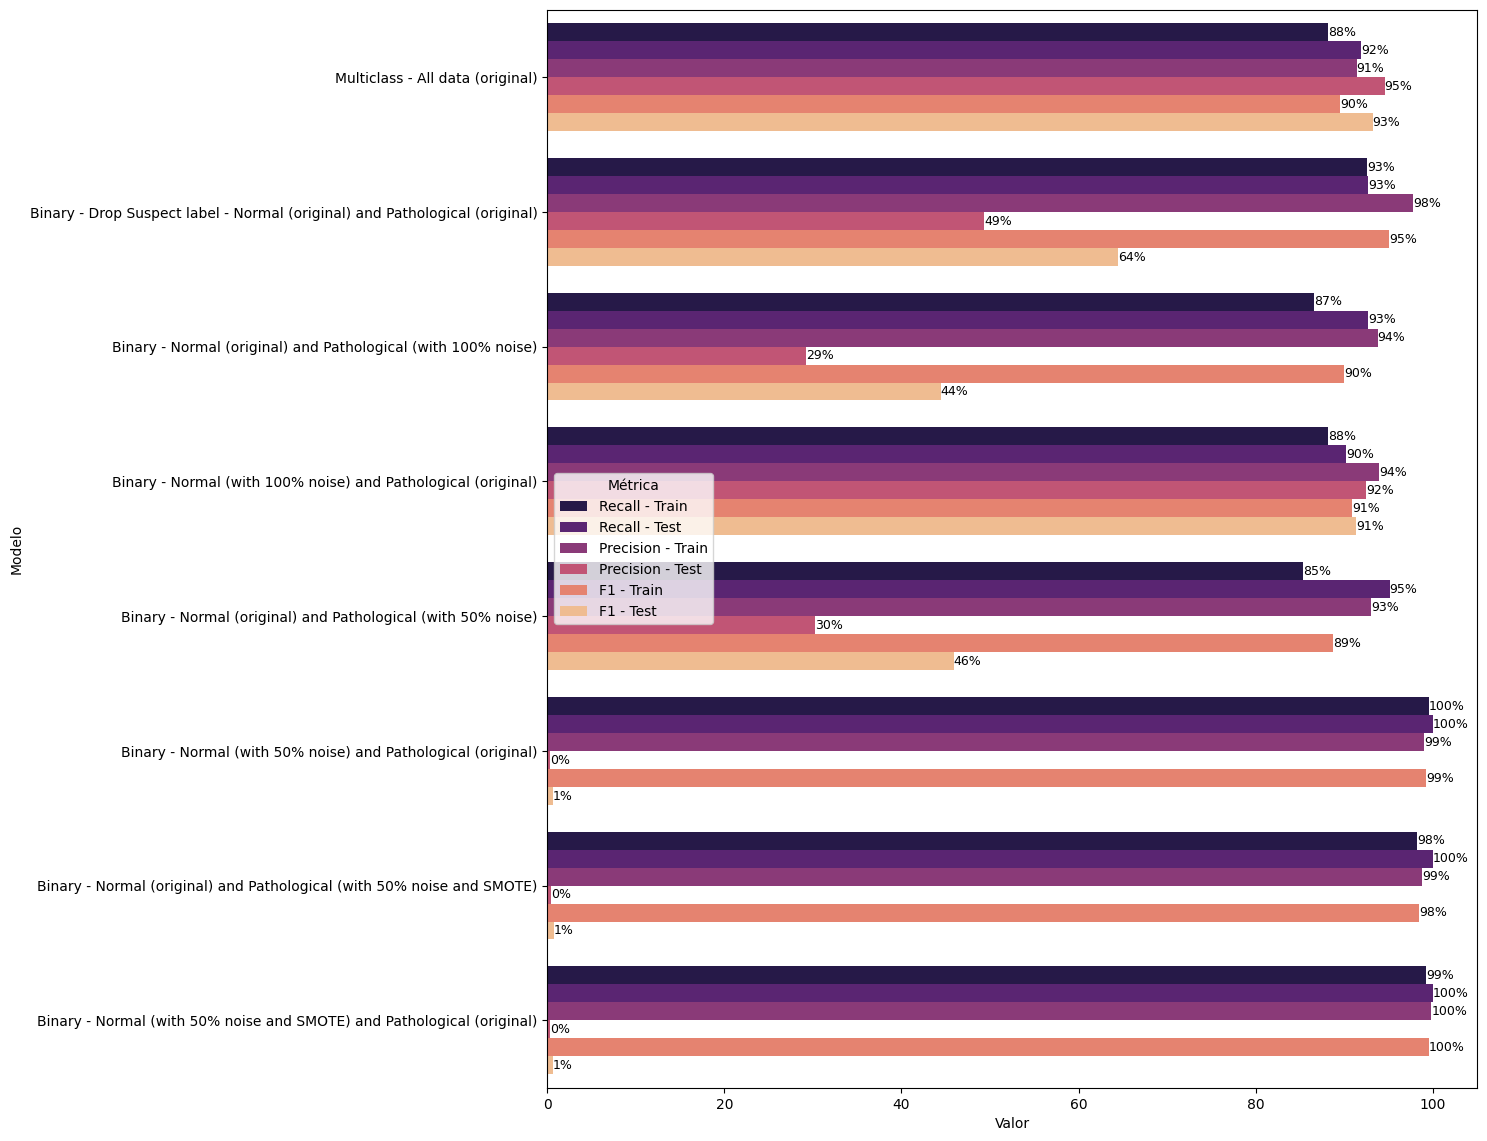

In [43]:
df_melted = df_results.melt(id_vars='Modelo', 
                            value_vars=['Recall - Train', 'Recall - Test', 'Precision - Train', 'Precision - Test', 'F1 - Train', 'F1 - Test'], 
                            var_name='Métrica', 
                            value_name='Valor')
plt.figure(figsize=(12,14))
ax = sns.barplot(data=df_melted, y='Modelo', x='Valor', hue='Métrica', palette='magma')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%', label_type='edge', fontsize=9)
plt.legend(title='Métrica', loc='center left') 
plt.show()